# Our primary task is to develop a classification model or generative AI application to distinguish between legitimate (non-spam) and spam messages.

## I propose three approaches to develop our spam detection model.
   1. Traditional machine learning classification models
       *   Logistic Regression
       *   Random Forest
       *   XGBoost
       *   Stacked Classifier

   2. Deep Learning technique
       *   RNNs : LSTM model
    
   3. Large Language Models
       *   RoBERTa : BERT-like LLM
       *   MistralAI : GenAI LLM 7B parameters

## In this notebook, I will explore the Large Language Model approach. In previous notebook we discussed finetuned RoBERTa model. In this notebook we will explore plain and finetuned MistralAI LLMs to develop our Spam detection model. I have used NVIDIA A100 GPU runtime for this notebook.

In case of plain LLM, we will just design a prompt to detect spam message. In case of finetuned model, we will use Reinforcement QLoRA finetuning to train our model on the dataset.

### Plain MistralAI LLM

In [ ]:
#Install necessary libraries and packages
!pip -q install langchain tiktoken chromadb pypdf transformers InstructorEmbedding
!pip -q install accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.6/508.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Import the BitsAndBytesConfig library to simplify the process of model quantization

from transformers import BitsAndBytesConfig
import torch

#Use the 4-bit quantization to reduce the memory usage by approximately fourfold
#Change compute data type to torch.bfloat16 to improve the speed

bnb_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.bfloat16)

In [ ]:
import torch
import transformers

# Import AutoModelForCasualLM as Mistral has CausalLm configuration class
from huggingface_hub import login

login("huggin face key")
from transformers import AutoTokenizer, AutoModelForCausalLM

#Setup tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

# Load pre-trained Mistral model for causal language modeling
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1",
                                              quantization_config=bnb_config,
                                              device_map='auto',
                                              low_cpu_mem_usage=True)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
#Let's ask plain LLM to detect the category of a few questions.
text = """
I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oh k...i'm watching here:)

Your answer:
"""
inputs = tokenizer(text, return_tensors="pt")
inputs= inputs.to('cuda')
outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

text = """
I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.
Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Your answer:
"""
inputs = tokenizer(text, return_tensors="pt")
inputs= inputs.to('cuda')
outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

text = """
I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Had your mobile 11 months or more?
 U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030

Your answer:
"""
inputs = tokenizer(text, return_tensors="pt")
inputs= inputs.to('cuda')
outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

text = """
I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Your answer:
"""
inputs = tokenizer(text, return_tensors="pt")
inputs= inputs.to('cuda')
outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oh k...i'm watching here:)

Your answer:
spam


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.
Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Your answer:
spam


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Had your mobile 11 months or more?
 U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030

Your answer:
spam

I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Your answer:
spam


In [ ]:
#Load test data to evaluate plain LLM
import pandas as pd
test_data=pd.read_csv("test_data.csv")


In [ ]:
#Evaluate the plain LLM over test dataset
prompts=test_data["message"].tolist()
Labels=[]

for i in range(len(prompts)):
  print(i)
  text= f"""
I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:{prompts[i]}

Your answer:
"""
  inputs = tokenizer(text, return_tensors="pt")
  inputs= inputs.to('cuda')
  outputs = model.generate(**inputs, max_new_tokens=20)
  answer=tokenizer.decode(outputs[0], skip_special_tokens=True)
  Labels.append(answer)
  print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


0


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"\Gimme a few\"" was  &lt;#&gt;  minutes ago"""

Your answer:
spam
1


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:excellent. I spent  &lt;#&gt;  years in the Air Force. Iraq and afghanistan. I am stable and honest. do you like traveling?

Your answer:
spam
2


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yo guess what I just dropped

Your answer:
spam
3


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm really not up to it still tonight babe

Your answer:

I'm really not up to it still tonight babe

Your answer:


4


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Have you emigrated or something? Ok maybe 5.30 was a bit hopeful...

Your answer:
spam
5


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Fair enough, anything going on?"

Your answer:

spam
6


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sent me ur email id soon

Your answer:
spam
7


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Jesus armand really is trying to tell everybody he can find

Your answer:
spam
8


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Ill call u 2mrw at ninish, with my address that icky American freek wont stop callin me 2 bad Jen k eh?"

Your answer:
spam
9


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Stop knowing me so well!

Your answer:
spam
10


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey so whats the plan this sat?

Your answer:





















11


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Great. Have a safe trip. Dont panic surrender all.

Your answer:
spam
12


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yes:)here tv is always available in work place..

Your answer:
spam
13


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Unlimited texts. Limited minutes.

Your answer:
spam
14


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Prabha..i'm soryda..realy..frm heart i'm sory

Your answer:
spam
15


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hmmm ... I thought we said 2 hours slave, not 3 ... You are late ... How should I punish you ?"

Your answer:
spam
16


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Of cos can lar i'm not so ba dao ok... 1 pm lor... Y u never ask where we go ah... I said u would ask on fri but he said u will ask today...

Your answer:
spam
17


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oops. 4 got that bit.

Your answer:

I have received a message. I want to identify whether it's spam or not.
18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey i'm bored... So i'm thinking of u... So wat r u doing?

Your answer:
spam
19


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I am in hospital da. . I will return home in evening

Your answer:
spam
20


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry man, my stash ran dry last night and I can't pick up more until sunday"

Your answer:
spam
21


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Oops, I'll let you know when my roommate's done"

Your answer:

spam
22


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hello! How's you and how did saturday go? I was just texting to see if you'd decided to do anything tomo. Not that i'm trying to invite myself or anything!

Your answer:
spam
23


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Good afternoon, my love ! Any job prospects ? Are you missing me ? What do you do ? Are you being lazy and bleak, hmmm ? Or happy and filled with my love ?"

Your answer:
spam
24


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I think chennai well settled?

Your answer:
spam
25


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"OH MR SHEFFIELD! You wanna play THAT game, okay. You're the boss and I'm the nanny. You give me a raise and I'll give YOU one!!"

Your answer:
spam
26


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Lol that's different. I don't go trying to find every real life photo you ever took.

Your answer:
spam
27


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ofcourse I also upload some songs

Your answer:
spam
28


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I've not called you in a while. This is hoping it was l8r malaria and that you know that we miss you guys. I miss Bani big, so pls give her my love especially. Have a great day."

Your answer:
spam
29


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hello! Just got here, st andrews-boy its a long way! Its cold. I will keep you posted"

Your answer:
spam
30


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Jos ask if u wana meet up?

Your answer:
spam
31


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Good day to You too.Pray for me.Remove the teeth as its painful maintaining other stuff.

Your answer:
spam
32


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Mm so you asked me not to call radio

Your answer:
spam
33


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"If i let you do this, i want you in the house by 8am."

Your answer:
spam
34


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"It doesnt make sense to take it there unless its free. If you need to know more, wikipedia.com"

Your answer:
spam
35


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Noooooooo please. Last thing I need is stress. For once in your life be fair.

Your answer:
spam
36


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:When u wana see it then

Your answer:
spam
37


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:If you're not in my car in an hour and a half I'm going apeshit

Your answer:
spam
38


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"True. It is passable. And if you get a high score and apply for phd, you get 5years of salary. So it makes life easier."

Your answer:
spam
39


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do u noe wat time e place dat sells 4d closes?

Your answer:
spam
40


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Let me know how it changes in the next 6hrs. It can even be appendix but you are out of that age range. However its not impossible. So just chill and let me know in 6hrs

Your answer:
spam
41


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Haha awesome, omw back now then"

Your answer:

spam
42


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I can probably come by, everybody's done around  &lt;#&gt;  right?"

Your answer:
spam
43


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hi here. have birth at on the  to  at 8lb 7oz. Mother and baby doing brilliantly.

Your answer:
spam
44


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Well done, blimey, exercise, yeah, i kinda remember wot that is, hmm. "

Your answer:

spam
45


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:U don't remember that old commercial?

Your answer:
spam
46


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I think its far more than that but find out. Check google maps for a place from your dorm.

Your answer:
spam
47


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Now project pa. After that only i can come.

Your answer:
spam
48


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Howz pain.it will come down today.do as i said ystrday.ice and medicine.

Your answer:
spam
49


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I am on the way to tirupur.

Your answer:
spam
50


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Can you please send me my aunty's number

Your answer:
spam
51


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Prof: you have passed in all the papers in this sem congrats . . . . Student: Enna kalaachutaarama..!! Prof:???? Gud mrng!

Your answer:
spam
52


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:If you're thinking of lifting me one then no.

Your answer:
spam
53


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Get ready for  &lt;#&gt;  inches of pleasure...

Your answer:
spam
54


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No calls..messages..missed calls

Your answer:
spam
55


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Night night, see you tomorrow"

Your answer:

"spam"
56


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Indeed and by the way it was either or - not both !

Your answer:
spam
57


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"The affidavit says  &lt;#&gt;  E Twiggs St, division g, courtroom  &lt;#&gt; , &lt;TIME&gt;  AM. I'll double check and text you again tomorrow"

Your answer:
spam
58


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dont think you need yellow card for uk travel. Ask someone that has gone before. If you do its just  &lt;#&gt; bucks

Your answer:
spam
59


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry da thangam, very very sorry i am held up with prasad."

Your answer:
spam
60


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Got but got 2 colours lor. One colour is quite light n e other is darker lor. Actually i'm done she's styling my hair now.

Your answer:
spam
61


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:He remains a bro amongst bros

Your answer:
spam
62


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Missed your call cause I was yelling at scrappy. Miss u. Can't wait for u to come home. I'm so lonely today.

Your answer:
spam
63


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"HEY THERE BABE, HOW U DOIN? WOT U UP 2 2NITE LOVE ANNIE X."

Your answer:
spam
64


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hows the pain dear?y r u smiling?

Your answer:
spam
65


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hiya do u like the hlday pics looked horrible in them so took mo out! Hows the camp Amrca thing? Speak soon Serena:)

Your answer:
spam
66


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Well its not like you actually called someone a punto. That woulda been worse.

Your answer:
spam
67


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:And whenever you and i see we can still hook up too.

Your answer:
spam
68


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Jus finish bathing...

Your answer:

spam
69


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Remind me how to get there and I shall do so

Your answer:
spam
70


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hello, As per request from  &lt;#&gt;  Rs.5 has been transfered to you"

Your answer:
spam
71


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Well, I have to leave for my class babe ... You never came back to me ... :-( ... Hope you have a nice sleep, my love"

Your answer:
spam
72


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Those ducking chinchillas

Your answer:
spam
73


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Are you there in room.

Your answer:
spam
74


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Not sure I have the stomach for it ...

Your answer:
spam
75


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Its sunny in california. The weather's just cool

Your answer:
spam
76


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"HI HUN! IM NOT COMIN 2NITE-TELL EVERY1 IM SORRY 4 ME, HOPE U AVA GOODTIME!OLI RANG MELNITE IFINK IT MITE B SORTED,BUT IL EXPLAIN EVERYTHIN ON MON.L8RS.x"

Your answer:
spam
77


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I.ll give her once i have it. Plus she said grinule greet you whenever we speak

Your answer:
spam
78


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I wont do anything de.

Your answer:
spam
79


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Siva is in hostel aha:-.

Your answer:
spam
80


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Yar lor he wan 2 go c horse racing today mah, so eat earlier lor. I ate chicken rice. U?"

Your answer:
spam
81


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I cant pick the phone right now. Pls send a message

Your answer:
spam
82


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"The world is running and i am still.maybe all are feeling the same,so be it.or i have to admit,i am mad.then where is the correction?or let me call this is life.and keep running with the world,may be u r also running.lets run."

Your answer:
spam
83


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Long after I quit. I get on only like 5 minutes a day as it is.

Your answer:
spam
84


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hiya , have u been paying money into my account? If so, thanks. Got a pleasant surprise when i checked my balance -u c, i don't get statements 4 that acc"

Your answer:
spam
85


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I will come tomorrow di

Your answer:
spam
86


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dont put your phone on silent mode ok

Your answer:
spam
87


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I HAVE A DATE ON SUNDAY WITH WILL!!

Your answer:
spam
88


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:\Hey j! r u feeling any better

Your answer:
spam
89


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oh Howda gud gud.. Mathe en samachara chikku:-)

Your answer:
spam
90


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hmm, too many of them unfortunately... Pics obviously arent hot cakes. Its kinda fun tho"

Your answer:
spam
91


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:She doesnt need any test.

Your answer:
spam
92


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Die... I accidentally deleted e msg i suppose 2 put in e sim archive. Haiz... I so sad...

Your answer:
spam
93


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sun ah... Thk mayb can if dun have anythin on... Thk have to book e lesson... E pilates is at orchard mrt u noe hor...

Your answer:
spam
94


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Rose needs water, season needs change, poet needs imagination..My phone needs ur sms and i need ur lovely frndship forever...."

Your answer:
spam
95


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok i juz receive..

Your answer:
spam
96


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Mom wants to know where you at

Your answer:
spam
97


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I am late,so call you tomorrow morning.take care sweet dreams....u and me...ummifying...bye."

Your answer:
spam
98


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Kate jackson rec center before 7ish, right?"

Your answer:
spam
99


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Good afternoon starshine! How's my boytoy? Does he crave me yet? Ache to fuck me ? *sips cappuccino* I miss you babe *teasing kiss*

Your answer:
spam
100


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Its sarcasm.. .nt scarcasim

Your answer:
spam
101


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Go where n buy? Juz buy when we get there lar.

Your answer:
spam
102


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Im done. Just studyn in library

Your answer:
spam
103


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Its ok., i just askd did u knw tht no?"

Your answer:
spam
104


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:What time you coming down later?

Your answer:
spam
105


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Smith waste da.i wanna gayle.

Your answer:
spam
106


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Its ok, called mom instead have fun"

Your answer:

spam
107


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Dear friends, sorry for the late information. Today is the birthday of our loving Ar.Praveesh. for more details log on to face book and see. Its his number + &lt;#&gt; . Dont miss a delicious treat."

Your answer:
spam
108


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok no prob. Take ur time.

Your answer:
spam
109


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Let me know how to contact you. I've you settled in a room. Lets know you are ok.

Your answer:
spam
110


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey sexy buns! What of that day? No word from you this morning on YM ... :-( ... I think of you

Your answer:
spam
111


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I am joining today formally.Pls keep praying.will talk later.

Your answer:
spam
112


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Not yet chikku..going to room nw, i'm in bus.."

Your answer:

spam
113


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:U definitely need a module from e humanities dis sem izzit? U wan 2 take other modules 1st?

Your answer:
spam
114


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I dont have i shall buy one dear

Your answer:
spam
115


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Huh y lei...

Your answer:
spam
116


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:How are you. Wish you a great semester

Your answer:
spam
117


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry, I'll call later"

Your answer:

spam
118


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:They released vday shirts and when u put it on it makes your bottom half naked instead of those white underwear.

Your answer:
spam
119


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:That was random saw my old roomate on campus. He graduated

Your answer:
spam
120


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Wot about on wed nite I am 3 then but only til 9!

Your answer:
spam
121


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Damn, can you make it tonight or do you want to just wait til tomorrow"

Your answer:

spam
122


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Mm not entirely sure i understood that text but hey. Ho. Which weekend?

Your answer:
spam
123


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"New Theory: Argument wins d SITUATION, but loses the PERSON. So dont argue with ur friends just.. . . . kick them &amp; say, I'm always correct.!"

Your answer:
spam
124


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Our Prashanthettan's mother passed away last night. pray for her and family.

Your answer:
spam
125


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry, I'll call later"

Your answer:

spam
126


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm also came to room.

Your answer:
spam
127


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dude got a haircut. Now its breezy up there

Your answer:
spam
128


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Are you willing to go for apps class.

Your answer:

I have received a message. I want to identify whether it's spam or not.
129


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"(And my man carlos is definitely coming by mu tonight, no excuses)"

Your answer:
spam
130


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Ugh y can't u just apologize, admit u were wrong and ask me to take u back?"

Your answer:
spam
131


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey you told your name to gautham ah?

Your answer:
spam
132


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:WHO ARE YOU SEEING?

Your answer:

I have received a message. I want to identify whether it's spam or not.
133


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm good. Have you registered to vote?

Your answer:
spam
134


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:In xam hall boy asked girl Tell me the starting term for dis answer I can den manage on my own After lot of hesitation n lookin around silently she said THE! intha ponnungale ipaditan;)

Your answer:
spam
135


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"My life Means a lot to me, Not because I love my life, But because I love the people in my life, The world calls them friends, I call them my World:-).. Ge:-).."

Your answer:

spam
136


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:All these nice new shirts and the only thing I can wear them to is nudist themed ;_; you in mu?

Your answer:
spam
137


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Then get some cash together and I'll text jason

Your answer:
spam
138


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx

Your answer:
spam
139


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Love isn't a decision, it's a feeling. If we could decide who to love, then, life would be much simpler, but then less magical"

Your answer:

Ham
140


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:But you were together so you should be thinkin about him

Your answer:
spam
141


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I have no money 4 steve mate! !

Your answer:
spam
142


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey what are you doing. Y no reply pa..

Your answer:
spam
143


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I think your mentor is , but not 100 percent sure."

Your answer:

I think your mentor is , but not 100 percent sure.

Your
144


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Mm feeling sleepy. today itself i shall get that dear

Your answer:
spam
145


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do you mind if I ask what happened? You dont have to say if it is uncomfortable.

Your answer:

I have received a message. I want to identify whether it's spam or not.
146


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I also thk too fast... Xy suggest one not me. U dun wan it's ok. Going 2 rain leh where got gd.

Your answer:
spam
147


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Goodnight da thangam I really miss u dear.

Your answer:
spam
148


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Who were those people ? Were you in a tour ? I thought you were doing that sofa thing you sent me ? Your curious sugar

Your answer:
spam
149


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I wont touch you with out your permission.

Your answer:
spam
150


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Good afternon, my love. How are today? I hope your good and maybe have some interviews. I wake and miss you babe. A passionate kiss from across the sea"

Your answer:

spam
151


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:May i call You later Pls

Your answer:
spam
152


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:What was she looking for?

Your answer:

Ham
153


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:What's nannys address?

Your answer:
spam
154


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No da if you run that it activate the full version da.

Your answer:
spam
155


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Can you open the door?

Your answer:
spam
156


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I was about to do it when i texted. I finished a long time ago and showered and er'ything!

Your answer:
spam
157


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ha... Then we must walk to everywhere... Cannot take tram. My cousin said can walk to vic market from our hotel

Your answer:
spam
158


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Thankyou so much for the call. I appreciate your care.

Your answer:
spam
159


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!

Your answer:
spam
160


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Been up to ne thing interesting. Did you have a good birthday? When are u wrking nxt? I started uni today.

Your answer:
spam
161


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:In the end she might still vomit but its okay. Not everything will come out.

Your answer:
spam
162


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I'm an actor. When i work, i work in the evening and sleep late. Since i'm unemployed at the moment, i ALWAYS sleep late. When you're unemployed, every day is saturday."

Your answer:
spam
163


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do we have any spare power supplies

Your answer:
spam
164


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?

Your answer:
spam
165


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:As per your request 'Maangalyam (Alaipayuthe)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

Your answer:
spam
166


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Time n Smile r the two crucial things in our life. Sometimes time makes us to forget smile, and sometimes someone's smile makes us to forget time gud noon"

Your answer:
spam
167


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Aiyah ok wat as long as got improve can already wat...

Your answer:
spam
168


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:U sick still can go shopping?

Your answer:
spam
169


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Normally i use to drink more water daily:)

Your answer:
spam
170


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Well I might not come then...

Your answer:
spam
171


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Depends on where u going lor.

Your answer:





















172


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sorry dude. Dont know how i forgot. Even after Dan reminded me. Sorry. Hope you guys had fun.

Your answer:
spam
173


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sounds like something that someone testing me would sayy

Your answer:
spam
174


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Doc prescribed me morphine cause the other pain meds aren't enough. Waiting for my mom to bring it. That med should kick in fast so I'm gonna try to be on later

Your answer:
spam
175


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:So its to be poking man everyday that they teach you in canada abi! How are you. Just saying hi.

Your answer:
spam
176


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Thanks for this hope you had a good day today

Your answer:

I have received a message. I want to identify whether it's spam or not.
177


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Can i get your opinion on something first?

Your answer:
spam
178


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Do you know why god created gap between your fingers..? So that, One who is made for you comes &amp; fills those gaps by holding your hand with LOVE..!"

Your answer:
spam
179


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Are you going to write ccna exam this week??

Your answer:
spam
180


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok lor...

Your answer:
spam
181


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Nope. I just forgot. Will show next week

Your answer:
spam
182


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Good Morning plz call me sir

Your answer:
spam
183


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I did. One slice and one breadstick. Lol

Your answer:

I did. One slice and one breadstick. Lol

Your answer:

sp
184


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:K I'll be there before 4.

Your answer:

I have received a message. I want to identify whether it's spam or not.
185


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Watching cartoon, listening music &amp; at eve had to go temple &amp; church.. What about u?"

Your answer:
spam
186


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sorry about that this is my mates phone and i didnt write it love Kate

Your answer:
spam
187


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:K. I will sent it again

Your answer:
spam
188


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Dear relieved of westonzoyland, all going to plan this end too!"

Your answer:
spam
189


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:One of the joys in lifeis waking up each daywith thoughts that somewhereSomeone cares enough tosend a warm morning greeting.. -

Your answer:

Ham
190


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:what number do u live at? Is it 11?

Your answer:
spam
191


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sorry i've not gone to that place. I.ll do so tomorrow. Really sorry.

Your answer:
spam
192


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I jus reached home. I go bathe first. But my sis using net tell u when she finishes k...

Your answer:
spam
193


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sorry. You never hear unless you book it. One was kinda a joke--thet were really looking for skinny white girls. The other was one line--you can only do so much on camera with that. Something like that they're casting on the look.

Your answer:
spam
194


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..

Your answer:
spam
195


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"It's ok, at least armand's still around"

Your answer:

spam
196


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Lol! Oops sorry! Have fun.

Your answer:
spam
197


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Wat so late still early mah. Or we juz go 4 dinner lor. Aiya i dunno...

Your answer:
spam
198


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Customer place i will call you

Your answer:
spam
199


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Am on the uworld site. Am i buying the qbank only or am i buying it with the self assessment also?

Your answer:
spam
200


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Not yet had..ya sapna aunty manege y'day hogidhe..chinnu full weak and swalpa black agidhane..

Your answer:
spam
201


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Whos this am in class:-)

Your answer:
spam
202


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:If you have belive me. Come to my home.

Your answer:
spam
203


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Update your face book status frequently :)

Your answer:
spam
204


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Wot u up 2 u weirdo?

Your answer:
spam
205


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yetunde i'm in class can you not run water on it to make it ok. Pls now.

Your answer:
spam
206


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"A Boy loved a gal. He propsd bt she didnt mind. He gv lv lttrs, Bt her frnds threw thm. Again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal. Wn it was about 2 hit d girl,d boy ran like hell n saved her. She asked 'hw cn u run so fast?' D boy replied \Boost is d secret of my energy\"" n instantly d girl shouted \""our energy\"" n Thy lived happily 2gthr drinking boost evrydy Moral of d story:- I hv free msgs:D;): gud ni8"""

Your answer:
spam
207


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yup... Hey then one day on fri we can ask miwa and jiayin take leave go karaoke

Your answer:
spam
208


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do you know when the result.

Your answer:
spam
209


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oh shut it. Omg yesterday I had a dream that I had 2 kids both boys. I was so pissed. Not only about the kids but them being boys. I even told mark in my dream that he was changing diapers cause I'm not getting owed in the face.

Your answer:
spam
210


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Watching tv now. I got new job :)

Your answer:
spam
211


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok. I asked for money how far

Your answer:
spam
212


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Garbage bags, eggs, jam, bread, hannaford wheat chex"

Your answer:
spam
213


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:It's ok i wun b angry. Msg u aft i come home tonight.

Your answer:
spam
214


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm always looking for an excuse to be in the city.

Your answer:
spam
215


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I was gonna ask you lol but i think its at 7

Your answer:
spam
216


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry, I'll call later"

Your answer:

spam
217


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Ditto. And you won't have to worry about me saying ANYTHING to you anymore. Like i said last night, you do whatever you want and i'll do the same. Peace."

Your answer:
spam
218


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:HAPPY NEW YEAR MY NO.1 MAN

Your answer:
spam
219


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Erm... Woodland avenue somewhere. Do you get the parish magazine, his telephone number will be in there."

Your answer:
spam
220


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sorry da. I gone mad so many pending works what to do.

Your answer:
spam
221


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Exactly. Anyways how far. Is jide her to study or just visiting

Your answer:
spam
222


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Jay is snickering and tells me that x is totally fucking up the chords as we speak

Your answer:
spam
223


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Its a site to simulate the test. It just gives you very tough questions to test your readiness.

Your answer:
spam
224


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Babe! I fucking love you too !! You know? Fuck it was so good to hear your voice. I so need that. I crave it. I can't get enough. I adore you, Ahmad *kisses*"

Your answer:
spam
225


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:(That said can you text him one more time?)

Your answer:
spam
226


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Any pain on urination any thing else?

Your answer:
spam
227


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"idc get over here, you are not weaseling your way out of this shit twice in a row"

Your answer:
spam
228


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Eat at old airport road... But now 630 oredi... Got a lot of pple...

Your answer:
spam
229


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry pa, i dont knw who ru pa?"

Your answer:
spam
230


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey! There's veggie pizza... :/

Your answer:
spam
231


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:", im .. On the snowboarding trip. I was wondering if your planning to get everyone together befor we go..a meet and greet kind of affair? Cheers, "

Your answer:

I have received a message. I want to identify whether it's spam or not.
232


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I'm in solihull, | do you want anything?"

Your answer:
spam
233


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I wonder if you'll get this text?

Your answer:
spam
234


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Lol! Nah wasn't too bad thanks. Its good to b home but its been quite a reality check. Hows ur day been? Did u do anything with website?

Your answer:

I have received a message. I want to identify whether it's spam or not.
235


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams

Your answer:
spam
236


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:3 pa but not selected.

Your answer:
spam
237


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Aight, I'll text you when I'm back"

Your answer:

spam
238


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Are you wet right now?

Your answer:
spam
239


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Did u got that persons story

Your answer:
spam
240


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"So many people seems to be special at first sight, But only very few will remain special to you till your last sight.. Maintain them till life ends.. Sh!jas"

Your answer:
spam
241


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey... are you going to quit soon? Xuhui and i working till end of the month

Your answer:
spam
242


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Then u go back urself lor...

Your answer:
spam
243


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yeah jay's sort of a fucking retard

Your answer:
spam
244


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sat right? Okay thanks...

Your answer:
spam
245


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry, went to bed early, nightnight"

Your answer:

spam
246


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Tomorrow i am not going to theatre. . . So i can come wherever u call me. . . Tell me where and when to come tomorrow

Your answer:
spam
247


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Cool, want me to go to kappa or should I meet you outside mu"

Your answer:

spam
248


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Lol you forgot it eh ? Yes, I'll bring it in babe"

Your answer:
spam
249


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Thanx 4 e brownie it's v nice...

Your answer:
spam
250


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:How's it feel? Mr. Your not my real Valentine just my yo Valentine even tho u hardly play!!

Your answer:
spam
251


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:S:)8 min to go for lunch:)

Your answer:
spam
252


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I can make lasagna for you... vodka...

Your answer:
spam
253


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Once a fishrman woke early in d mrng. It was very dark. He waited a while &amp; found a sack ful of stones. He strtd throwin thm in2 d sea 2 pass time. Atlast he had jus 1stone, sun rose up &amp; he found out tht those r nt stones, those were diamonds. Moral:\Dont wake up early in d mrng'' GOOD night"""

Your answer:
spam
254


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:The world's most happiest frnds never have the same characters... Dey just have the best understanding of their differences...

Your answer:
spam
255


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:The Xmas story is peace.. The Xmas msg is love.. The Xmas miracle is jesus.. Hav a blessed month ahead &amp; wish U Merry Xmas...

Your answer:
spam
256


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I guess that's why you re worried. You must know that there's a way the body repairs itself. And i'm quite sure you shouldn't worry. We'll take it slow. First the tests, they will guide when your ovulation is then just relax. Nothing you've said is a reason to worry but i.ll keep on followin you up."

Your answer:
spam
257


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Faith makes things possible,Hope makes things work,Love makes things beautiful,May you have all three this Christmas!Merry Christmas!"

Your answer:

Ham
258


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Pandy joined 4w technologies today.he got job..

Your answer:
spam
259


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us"

Your answer:
spam
260


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"K, text me when you're on the way"

Your answer:
spam
261


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:When you guys planning on coming over?

Your answer:
spam
262


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I finished my lunch already. U wake up already?

Your answer:
spam
263


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:In other news after hassling me to get him weed for a week andres has no money. HAUGHAIGHGTUJHYGUJ

Your answer:
spam
264


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No one interested. May be some business plan.

Your answer:
spam
265


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:He didn't see his shadow. We get an early spring yay

Your answer:
spam
266


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Wah lucky man... Then can save money... Hee...

Your answer:
spam
267


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hello hun how ru? Its here by the way. Im good. Been on 2 dates with that guy i met in walkabout so far. We have to meet up soon. Hows everyone else?

Your answer:
spam
268


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Is she replying. Has boye changed his phone number

Your answer:
spam
269


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:S.i'm watching it in live..

Your answer:
spam
270


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"K, I might come by tonight then if my class lets out early"

Your answer:

spam
271


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I got like $ &lt;#&gt; , I can get some more later though. Get whatever you feel like"

Your answer:
spam
272


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Thk some of em find wtc too far... Weiyi not goin... E rest i dunno yet... R ur goin 4 dinner den i might b able to join...

Your answer:
spam
273


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Cool. Do you like swimming? I have a pool and jacuzzi at my house.

Your answer:
spam
274


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:NEFT Transaction with reference number  &lt;#&gt;  for Rs. &lt;DECIMAL&gt;  has been credited to the beneficiary account on  &lt;#&gt;  at  &lt;TIME&gt; : &lt;#&gt;

Your answer:
spam
275


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Nothing but we jus tot u would ask cos u ba gua... But we went mt faber yest... Yest jus went out already mah so today not going out... Jus call lor...

Your answer:
spam
276


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You getting back any time soon?

Your answer:
spam
277


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:That day you asked about anand number. Why:-)

Your answer:
spam
278


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I am in hospital da. . I will return home in evening

Your answer:
spam
279


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it..."

Your answer:
spam
280


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ha... U jus ate honey ar? So sweet...

Your answer:
spam
281


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yes :)it completely in out of form:)clark also utter waste.

Your answer:
spam
282


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:But i'm really really broke oh. No amount is too small even  &lt;#&gt;

Your answer:
spam
283


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Haven't heard anything and he's not answering my texts so I'm guessing he flaked. That said the jb is fantastic

Your answer:
spam
284


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok... Ur typical reply...

Your answer:
spam
285


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:At 4. Let's go to bill millers

Your answer:
spam
286


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"That's good, because I need drugs"

Your answer:
spam
287


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No need lar. Jus testing e phone card. Dunno network not gd i thk. Me waiting 4 my sis 2 finish bathing so i can bathe. Dun disturb u liao u cleaning ur room.

Your answer:
spam
288


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm e person who's doing e sms survey...

Your answer:
spam
289


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Never try alone to take the weight of a tear that comes out of ur heart and falls through ur eyes... Always remember a STUPID FRIEND is here to share... BSLVYL

Your answer:
spam
290


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yun buying... But school got offer 2000 plus only...

Your answer:
spam
291


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hmmm.. Thk sure got time to hop ard... Ya, can go 4 free abt... Muz call u to discuss liao... "

Your answer:
spam
292


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oooh I got plenty of those!

Your answer:
spam
293


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:ARR birthday today:) i wish him to get more oscar.

Your answer:
spam
294


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Carlos says he'll be at mu in  &lt;#&gt;  minutes

Your answer:
spam
295


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:What i told before i tell. Stupid hear after i wont tell anything to you. You dad called to my brother and spoken. Not with me.

Your answer:
spam
296


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"K, if u bored up just come to my home.."

Your answer:
spam
297


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Don know:)this week i'm going to tirunelvai da.

Your answer:
spam
298


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Change again... It's e one next to escalator...

Your answer:
spam
299


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I love ya too but try and budget your money better babe. Gary would freak on me if he knew

Your answer:
spam
300


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:HIYA COMIN 2 BRISTOL 1 ST WEEK IN APRIL. LES GOT OFF + RUDI ON NEW YRS EVE BUT I WAS SNORING.THEY WERE DRUNK! U BAK AT COLLEGE YET? MY WORK SENDS INK 2 BATH.

Your answer:
spam
301


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I'm back &amp; we're packing the car now, I'll let you know if there's room"

Your answer:
spam
302


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Derp. Which is worse, a dude who always wants to party or a dude who files a complaint about the three drug abusers he lives with"

Your answer:
spam
303


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Well. Im computerless. Time to make some oreo truffles

Your answer:
spam
304


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dont kick coco when he's down

Your answer:
spam
305


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok no prob...

Your answer:
spam
306


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Me i'm not workin. Once i get job...

Your answer:
spam
307


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Convey my regards to him

Your answer:
spam
308


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Honeybee Said: *I'm d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Reading This Msg* MORAL: Even GOD Can Crack Jokes! GM+GN+GE+GN:)"

Your answer:
spam
309


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free

Your answer:
spam
310


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"You are everywhere dirt, on the floor, the windows, even on my shirt. And sometimes when i open my mouth, you are all that comes flowing out. I dream of my world without you, then half my chores are out too. A time of joy for me, lots of tv shows i.ll see. But i guess like all things you just must exist, like rain, hail and mist, and when my time here is done, you and i become one."

Your answer:
spam
311


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oooh bed ridden ey? What are YOU thinking of?

Your answer:
spam
312


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Some of them told accenture is not confirm. Is it true.

Your answer:
spam
313


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Your dad is back in ph?

Your answer:
spam
314


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Oh ho. Is this the first time u use these type of words

Your answer:
spam
315


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Merry christmas to u too annie!

Your answer:
spam
316


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Desires- u going to doctor 4 liver. And get a bit stylish. Get ur hair managed. Thats it.

Your answer:
spam
317


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:" said kiss, kiss, i can't do the sound effects! He is a gorgeous man isn't he! Kind of person who needs a smile to brighten his day! "

Your answer:

I have received a message. I want to identify whether it's spam or not.
318


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Good evening! this is roger. How are you?

Your answer:
spam
319


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Fighting with the world is easy, u either win or lose bt fightng with some1 who is close to u is dificult if u lose - u lose if u win - u still lose."

Your answer:
spam
320


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"K, I'll work something out"

Your answer:

spam
321


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sitting ard nothing to do lor. U leh busy w work?

Your answer:
spam
322


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Cool, we shall go and see, have to go to tip anyway. Are you at home, got something to drop in later? So lets go to town tonight! Maybe mum can take us in."

Your answer:

spam
323


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Meeting u is my work. . . Tel me when shall i do my work tomorrow

Your answer:
spam
324


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:THING R GOOD THANX GOT EXAMS IN MARCH IVE DONE NO REVISION? IS FRAN STILL WITH BOYF? IVE GOTTA INTERVIW 4 EXETER BIT WORRIED!x

Your answer:
spam
325


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Not planned yet :)going to join company on jan 5 only.don know what will happen after that.

Your answer:
spam
326


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hi.what you think about match?

Your answer:
spam
327


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Auntie huai juan never pick up her phone

Your answer:
spam
328


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:NOT MUCH NO FIGHTS. IT WAS A GOOD NITE!!

Your answer:
spam
329


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You should get more chicken broth if you want ramen unless there's some I don't know about

Your answer:
spam
330


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:But i haf enuff space got like 4 mb...

Your answer:
spam
331


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok.

Your answer:

I have received a message. I want to identify whether it's spam or not.
332


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Maybe i could get book out tomo then return it immediately ..? Or something.

Your answer:
spam
333


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Aiyar dun disturb u liao... Thk u have lots 2 do aft ur cupboard come...

Your answer:
spam
334


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"its cool but tyler had to take off so we're gonna buy for him and drop it off at his place later tonight. Our total order is a quarter, you got enough?"

Your answer:

spam
335


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:great princess! I love giving and receiving oral. Doggy style is my fave position. How about you? I enjoy making love  &lt;#&gt;  times per night :)

Your answer:
spam
336


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dai i downloaded but there is only exe file which i can only run that exe after installing.

Your answer:
spam
337


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there."

Your answer:
spam
338


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm thinking that chennai forgot to come for auction..

Your answer:
spam
339


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Buzz! Hey, my Love ! I think of you and hope your day goes well. Did you sleep in ? I miss you babe. I long for the moment we are together again*loving smile*"

Your answer:
spam
340


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Today is ACCEPT DAY..U Accept me as? Brother Sister Lover Dear1 Best1 Clos1 Lvblefrnd Jstfrnd Cutefrnd Lifpartnr Belovd Swtheart Bstfrnd No rply means enemy

Your answer:
spam
341


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Good afternoon on this glorious anniversary day, my sweet J !! I hope this finds you happy and content, my Prey. I think of you and send a teasing kiss from across the sea coaxing images of fond souveniers ... You Cougar-Pen"

Your answer:
spam
342


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Did you show him and wot did he say or could u not c him 4 dust?

Your answer:
spam
343


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"He said that he had a right giggle when he saw u again! You would possibly be the first person2die from NVQ, but think how much you could for! "

Your answer:
spam
344


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"No, its true..k,Do u knw dis no. &lt;#&gt; ?"

Your answer:
spam
345


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:How do friends help us in problems? They give the most stupid suggestion that Lands us into another problem and helps us forgt the previous problem

Your answer:
spam
346


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I want  &lt;#&gt;  rs da:)do you have it?

Your answer:
spam
347


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No..jst change tat only..

Your answer:
spam
348


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ha ha cool cool chikku chikku:-):-DB-)

Your answer:
spam
349


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Just send a text. We'll skype later.

Your answer:
spam
350


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Pls speak to that customer machan.

Your answer:
spam
351


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I donno its in your genes or something

Your answer:
spam
352


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"It's fine, imma get a drink or somethin. Want me to come find you?"

Your answer:

spam
353


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I thought i'd get him a watch, just cos thats the kind of thing u get4an18th. And he loves so much!"

Your answer:
spam
354


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ugh my leg hurts. Musta overdid it on mon.

Your answer:
ham
355


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Some friends want me to drive em someplace, probably take a while"

Your answer:

spam
356


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok. I only ask abt e movie. U wan ktv oso?

Your answer:
spam
357


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hey there! Glad u r better now. I hear u treated urself to a digi cam, is it good? We r off at 9pm. Have a fab new year, c u in coupla wks!"

Your answer:
spam
358


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sorry, left phone upstairs. OK, might be hectic but would be all my birds with one fell swoop. It's a date."

Your answer:
spam
359


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Theyre doing it to lots of places. Only hospitals and medical places are safe.

Your answer:
spam
360


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Thnx dude. u guys out 2nite?

Your answer:
spam
361


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yes. I come to nyc for audiitions and am trying to relocate.

Your answer:
spam
362


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:2 and half years i missed your friendship:-)

Your answer:
spam
363


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Aight, I'll ask a few of my roommates"

Your answer:
spam
364


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"sorry brah, just finished the last of my exams, what up"

Your answer:

spam
365


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No pic. Please re-send.

Your answer:
spam
366


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dude while were makin those weirdy brownies my sister made awesome cookies. I took pics.

Your answer:
spam
367


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:How abt making some of the pics bigger?

Your answer:
spam
368


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok but knackered. Just came home and went to sleep! Not good at this full time work lark.

Your answer:
spam
369


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May"

Your answer:
spam
370


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"I need an 8th but I'm off campus atm, could I pick up in an hour or two?"

Your answer:

spam
371


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:K come to nordstrom when you're done

Your answer:
spam
372


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Purity of friendship between two is not about smiling after reading the forwarded message..Its about smiling just by seeing the name. Gud evng musthu

Your answer:
spam
373


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I have to take exam with march 3

Your answer:
spam
374


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Mum say we wan to go then go... Then she can shun bian watch da glass exhibition...

Your answer:
spam
375


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hi Princess! Thank you for the pics. You are very pretty. How are you?

Your answer:
spam
376


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No i'm not gonna be able to. || too late notice. || i'll be home in a few weeks anyway. || what are the plans

Your answer:
spam
377


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Jay wants to work out first, how's 4 sound?"

Your answer:

spam
378


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Lol no. U can trust me.

Your answer:
spam
379


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:and  picking them up from various points

Your answer:

I have received a message. I want to identify whether it's spam or not.
380


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Tired. I haven't slept well the past few nights.

Your answer:
spam
381


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Quite late lar... Ard 12 anyway i wun b drivin...

Your answer:
spam
382


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dis is yijue. I jus saw ur mail. In case huiming havent sent u my num. Dis is my num.

Your answer:
spam
383


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sary just need Tim in the bollox &it hurt him a lot so he tol me!

Your answer:
spam
384


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ha ha ha good joke. Girls are situation seekers.

Your answer:
spam
385


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:BABE !!! I miiiiiiissssssssss you ! I need you !!! I crave you !!! :-( ... Geeee ... I'm so sad without you babe ... I love you ...

Your answer:
spam
386


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hope you are feeling great. Pls fill me in. Abiola

Your answer:
spam
387


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You also didnt get na hi hi hi hi hi

Your answer:
spam
388


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"\Response\"" is one of d powerful weapon 2 occupy a place in others 'HEART'... So"

Your answer:
spam
389


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Nope... Think i will go for it on monday... Sorry i replied so late

Your answer:
spam
390


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Also are you bringing galileo or dobby

Your answer:
spam
391


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ok lor... But buy wat?

Your answer:
spam
392


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:o turns out i had stereo love on mi phone under the unknown album.

Your answer:
spam
393


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'm freezing and craving ice. Fml

Your answer:
spam
394


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:The fact that you're cleaning shows you know why i'm upset. Your priority is constantly \what i want to do

Your answer:
spam
395


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Every day i use to sleep after  &lt;#&gt;  so only.

Your answer:
spam
396


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Yes.mum lookin strong:)

Your answer:
spam
397


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Becoz its  &lt;#&gt;  jan whn al the post ofice is in holiday so she cn go fr the post ofice...got it duffer

Your answer:
spam
398


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Have you heard about that job? I'm going to that wildlife talk again tonight if u want2come. Its that2worzels and a wizzle or whatever it is?!

Your answer:
spam
399


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:HCL chennai requires FRESHERS for voice process.Excellent english needed.Salary upto  &lt;#&gt; .Call Ms.Suman  &lt;#&gt;  for Telephonic interview -via Indyarocks.com

Your answer:
spam
400


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705.

Your answer:
spam
401


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do you want 750 anytime any network mins 150 text and a NEW VIDEO phone for only five pounds per week call 08002888812 or reply for delivery tomorrow

Your answer:
spam
402


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08712101358 NOW! Only 10p per min. BT-national-rate"

Your answer:
spam
403


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days.

Your answer:
spam
404


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:lyricalladie(21/F) is inviting you to be her friend. Reply YES-910 or NO-910. See her: www.SMS.ac/u/hmmross STOP? Send STOP FRND to 62468

Your answer:
spam
405


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Customer service announcement. We recently tried to make a delivery to you but were unable to do so, please call 07090298926 to re-schedule. Ref:9307622"

Your answer:
spam
406


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906

Your answer:
spam
407


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:This message is brought to you by GMW Ltd. and is not connected to the

Your answer:
spam
408


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:2p per min to call Germany 08448350055 from your BT line. Just 2p per min. Check PlanetTalkInstant.com for info & T's & C's. Text stop to opt out

Your answer:
spam
409


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FreeMsg: Fancy a flirt? Reply DATE now & join the UKs fastest growing mobile dating service. Msgs rcvd just 25p to optout txt stop to 83021. Reply DATE now!

Your answer:
spam
410


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:PRIVATE! Your 2004 Account Statement for 07742676969 shows 786 unredeemed Bonus Points. To claim call 08719180248 Identifier Code: 45239 Expires

Your answer:
spam
411


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Please CALL 08712402779 immediately as there is an urgent message waiting for you

Your answer:
spam
412


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Santa calling! Would your little ones like a call from Santa Xmas Eve? Call 09077818151 to book you time. Calls1.50ppm last 3mins 30s T&C www.santacalling.com

Your answer:
spam
413


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+

Your answer:
spam
414


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Please call Amanda with regard to renewing or upgrading your current T-Mobile handset free of charge. Offer ends today. Tel 0845 021 3680 subject to T's and C's

Your answer:
spam
415


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths+? Call MobilesDirect free on 08000938767 to update now! or2stoptxt T&Cs

Your answer:
spam
416


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Want the latest Video handset? 750 anytime any network mins? Half price line rental? Reply or call 08000930705 for delivery tomorrow

Your answer:
spam
417


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:* FREE* POLYPHONIC RINGTONE Text SUPER to 87131 to get your FREE POLY TONE of the week now! 16 SN PoBox202 NR31 7ZS subscription 450pw

Your answer:
spam
418


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Congrats! Nokia 3650 video camera phone is your Call 09066382422 Calls cost 150ppm Ave call 3mins vary from mobiles 16+ Close 300603 post BCM4284 Ldn WC1N3XX

Your answer:
spam
419


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Someone has contacted our dating service and entered your phone becausethey fancy you! To find out who it is call from a landline 09058098002. PoBox1, W14RG 150p"

Your answer:
spam
420


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FREE for 1st week! No1 Nokia tone 4 ur mobile every week just txt NOKIA to 8077 Get txting and tell ur mates. www.getzed.co.uk POBox 36504 W45WQ 16+ norm150p/tone

Your answer:
spam
421


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:TheMob>Yo yo yo-Here comes a new selection of hot downloads for our members to get for FREE! Just click & open the next link sent to ur fone...

Your answer:
spam
422


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Check Out Choose Your Babe Videos @ sms.shsex.netUN fgkslpoPW fgkslpo

Your answer:
spam
423


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:We tried to contact you re your reply to our offer of 750 mins 150 textand a new video phone call 08002988890 now or reply for free delivery tomorrow

Your answer:
spam
424


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ever thought about living a good life with a perfect partner? Just txt back NAME and AGE to join the mobile community. (100p/SMS)

Your answer:
spam
425


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Orange customer, you may now claim your FREE CAMERA PHONE upgrade for your loyalty. Call now on 0207 153 9996. Offer ends 14thMarch. T&C's apply. Opt-out availa"

Your answer:
spam
426


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Monthly password for wap. mobsi.com is 391784. Use your wap phone not PC.

Your answer:
spam
427


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:LORD OF THE RINGS:RETURN OF THE KING in store NOW!REPLY LOTR by 2 June 4 Chance 2 WIN LOTR soundtrack CDs StdTxtRate. Reply STOP to end txts

Your answer:
spam
428


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hard LIVE 121 chat just 60p/min. Choose your girl and connect LIVE. Call 09094646899 now! Cheap Chat UK's biggest live service. VU BCM1896WC1N3XX

Your answer:
spam
429


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Someone U know has asked our dating service 2 contact you! Cant Guess who? CALL 09058091854 NOW all will be revealed. PO BOX385 M6 6WU

Your answer:
spam
430


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Panasonic & BluetoothHdset FREE. Nokia FREE. Motorola FREE & DoubleMins & DoubleTxt on Orange contract. Call MobileUpd8 on 08000839402 or call 2optout

Your answer:
spam
431


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:network operator. The service is free. For T & C's visit 80488.biz

Your answer:
spam
432


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+

Your answer:
spam
433


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W45WQ norm150p/tone 16+

Your answer:
spam
434


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16

Your answer:
spam
435


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?"

Your answer:
spam
436


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Your answer:
spam
437


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur mob? Join the UK's largest Dogging Network bt Txting GRAVEL to 69888! Nt. ec2a. 31p.msg@150p

Your answer:
spam
438


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:sports fans - get the latest sports news str* 2 ur mobile 1 wk FREE PLUS a FREE TONE Txt SPORT ON to 8007 www.getzed.co.uk 0870141701216+ norm 4txt/120p

Your answer:
spam
439


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Sunshine Hols. To claim ur med holiday send a stamped self address envelope to Drinks on Us UK, PO Box 113, Bray, Wicklow, Eire. Quiz Starts Saturday! Unsub Stop"

Your answer:
spam
440


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066

Your answer:
spam
441


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send \go stop\"" to 89123"""

Your answer:
spam
442


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop

Your answer:
spam
443


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FreeMsg:Feelin kinda lnly hope u like 2 keep me company! Jst got a cam moby wanna c my pic?Txt or reply DATE to 82242 Msg150p 2rcv Hlp 08712317606 stop to 82242

Your answer:
spam
444


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:<Forwarded from 448712404000>Please CALL 08712404000 immediately as there is an urgent message waiting for you.

Your answer:
spam
445


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FREE camera phones with linerental from 4.49/month with 750 cross ntwk mins. 1/2 price txt bundle deals also avble. Call 08001950382 or call2optout/J MF

Your answer:
spam
446


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES"

Your answer:
spam
447


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send GO to 86688 only 150p/meg. CC: 08718720201 HG/Suite342/2lands Row/W1j6HL

Your answer:
spam
448


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"SMS SERVICES. for your inclusive text credits, pls goto www.comuk.net login= 3qxj9 unsubscribe with STOP, no extra charge. help 08702840625.COMUK. 220-CM2 9AE"

Your answer:
spam
449


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906

Your answer:
spam
450


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Bored housewives! Chat n date now! 0871750.77.11! BT-national rate 10p/min only from landlines!

Your answer:
spam
451


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt

Your answer:
spam
452


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:CALL 09090900040 & LISTEN TO EXTREME DIRTY LIVE CHAT GOING ON IN THE OFFICE RIGHT NOW TOTAL PRIVACY NO ONE KNOWS YOUR [sic] LISTENING 60P MIN 24/7MP 0870753331018+

Your answer:
spam
453


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dorothy@kiefer.com (Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..

Your answer:
spam
454


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free Top ringtone -sub to weekly ringtone-get 1st week free-send SUBPOLY to 81618-?3 per week-stop sms-08718727870

Your answer:
spam
455


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123

Your answer:
spam
456


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:ree entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+

Your answer:
spam
457


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.

Your answer:
spam
458


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:A link to your picture has been sent. You can also use http://alto18.co.uk/wave/wave.asp?o=44345

Your answer:
spam
459


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:RT-KIng Pro Video Club>> Need help? info@ringtoneking.co.uk or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!

Your answer:
spam
460


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:PRIVATE! Your 2003 Account Statement for 07808247860 shows 800 un-redeemed S. I. M. points. Call 08719899229 Identifier Code: 40411 Expires 06/11/04

Your answer:
spam
461


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:**FREE MESSAGE**Thanks for using the Auction Subscription Service. 18 . 150p/MSGRCVD 2 Skip an Auction txt OUT. 2 Unsubscribe txt STOP CustomerCare 08718726270

Your answer:
spam
462


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08715203694 Identifier Code: 40533 Expires 31/10/04

Your answer:
spam
463


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:8007 25p 4 Alfie Moon's Children in Need song on ur mob. Tell ur m8s. Txt TONE CHARITY to 8007 for nokias or POLY CHARITY for polys :zed 08701417012 profit 2 charity

Your answer:
spam
464


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free video camera phones with Half Price line rental for 12 mths and 500 cross ntwk mins 100 txts. Call MobileUpd8 08001950382 or Call2OptOut/674&

Your answer:
spam
465


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Not heard from U4 a while. Call 4 rude chat private line 01223585334 to cum. Wan 2C pics of me gettin shagged then text PIX to 8552. 2End send STOP 8552 SAM xxx

Your answer:
spam
466


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:What do U want for Xmas? How about 100 free text messages & a new video phone with half price line rental? Call free now on 0800 0721072 to find out more!

Your answer:
spam
467


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You are now unsubscribed all services. Get tons of sexy babes or hunks straight to your phone! go to http://gotbabes.co.uk. No subscriptions.

Your answer:
spam
468


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Mobile Club: Choose any of the top quality items for your mobile. 7cfca1a

Your answer:
spam
469


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Latest News! Police station toilet stolen, cops have nothing to go on!"

Your answer:
spam
470


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Cashbin.co.uk (Get lots of cash this weekend!) www.cashbin.co.uk Dear Welcome to the weekend We have got our biggest and best EVER cash give away!! These..

Your answer:
spam
471


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p"

Your answer:
spam
472


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Free Msg: get Gnarls Barkleys \Crazy\"" ringtone TOTALLY FREE just reply GO to this message right now!"""

Your answer:
spam
473


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Someonone you know is trying to contact you via our dating service! To find out who it could be call from your mobile or landline 09064015307 BOX334SK38ch

Your answer:
spam
474


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:dating:i have had two of these. Only started after i sent a text to talk sport radio last week. Any connection do you think or coincidence?

Your answer:
spam
475


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"U were outbid by simonwatson5120 on the Shinco DVD Plyr. 2 bid again, visit sms. ac/smsrewards 2 end bid notifications, reply END OUT"

Your answer:
spam
476


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Save money on wedding lingerie at www.bridal.petticoatdreams.co.uk Choose from a superb selection with national delivery. Brought to you by WeddingFriend

Your answer:
spam
477


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Thanks for your ringtone order, reference number X49. Your mobile will be charged 4.50. Should your tone not arrive please call customer services 09065989182. From: [colour=red]text[/colour]TXTstar"

Your answer:
spam
478


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd. Cust care 07821230901

Your answer:
spam
479


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56

Your answer:
spam
480


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do you want a New Nokia 3510i Colour Phone Delivered Tomorrow? With 200 FREE minutes to any mobile + 100 FREE text + FREE camcorder Reply or Call 08000930705

Your answer:
spam
481


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Please CALL 08712402972 immediately as there is an urgent message waiting for you

Your answer:
spam
482


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:As one of our registered subscribers u can enter the draw 4 a 100 G.B. gift voucher by replying with ENTER. To unsubscribe text STOP

Your answer:
spam
483


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"\For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk\"""""

Your answer:
spam
484


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Your answer:
spam
485


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:ringtoneking 84484

Your answer:
spam
486


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Urgent! call 09066350750 from your landline. Your complimentary 4* Ibiza Holiday or 10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP 150 ppm 18+ "

Your answer:
spam
487


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now!

Your answer:
spam
488


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No 1 POLYPHONIC tone 4 ur mob every week! Just txt PT2 to 87575. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info

Your answer:
spam
489


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:-PLS STOP bootydelious (32/F) is inviting you to be her friend. Reply YES-434 or NO-434 See her: www.SMS.ac/u/bootydelious STOP? Send STOP FRND to 62468

Your answer:
spam
490


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Tone Club: Your subs has now expired 2 re-sub reply MONOC 4 monos or POLYC 4 polys 1 weekly @ 150p per week Txt STOP 2 stop This msg free Stream 0871212025016

Your answer:
spam
491


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play Now! Send HMV to 86688 More info:www.100percent-real.com

Your answer:
spam
492


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Text & meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p. REPLY with NAME & AGE eg Sam 25. 18 -msg recd@thirtyeight pence

Your answer:
spam
493


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hi there, 2nights ur lucky night! Uve been invited 2 XCHAT, the Uks wildest chat! Txt CHAT to 86688 now! 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs"

Your answer:
spam
494


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"URGENT. Important information for 02 user. Today is your lucky day! 2 find out why , log onto http://www.urawinner.com there is a fantastic surprise awaiting you !"

Your answer:
spam
495


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have been specially selected to receive a 2000 pound award! Call 08712402050 BEFORE the lines close. Cost 10ppm. 16+. T&Cs apply. AG Promo

Your answer:
spam
496


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08712101358 NOW! Only 10p per min. BT-national-rate"

Your answer:
spam
497


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Money i have won wining number 946 wot do i do next

Your answer:
spam
498


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply"

Your answer:
spam
499


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"

Your answer:
spam
500


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry scores with a simple shot from 6 yards from a pass by Bergkamp to give Arsenal a 2 goal margin after 78 mins."

Your answer:

spam
501


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Had your mobile 10 mths? Update to the latest Camera/Video phones for FREE. KEEP UR SAME NUMBER, Get extra free mins/texts. Text YES for a call"

Your answer:
spam
502


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records."

Your answer:
spam
503


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.

Your answer:
spam
504


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Congrats 2 mobile 3G Videophones R yours. call 09063458130 now! videochat wid ur mates, play java games, Dload polypH music, noline rentl. bx420. ip4. 5we. 150p"

Your answer:
spam
505


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Bought one ringtone and now getting texts costing 3 pound offering more tones etc

Your answer:
spam
506


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have 1 new message. Please call 08715205273

Your answer:
spam
507


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Loans for any purpose even if you have Bad Credit! Tenants Welcome. Call NoWorriesLoans.com on 08717111821

Your answer:
spam
508


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Someone has contacted our dating service and entered your phone because they fancy you! To find out who it is call from a landline 09111032124 . PoBox12n146tf150p

Your answer:
spam
509


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Spook up your mob with a Halloween collection of a logo & pic message plus a free eerie tone, txt CARD SPOOK to 8007 zed 08701417012150p per logo/pic"

Your answer:
spam
510


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner

Your answer:
spam
511


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Dear Voucher Holder, To claim this weeks offer, at you PC please go to http://www.e-tlp.co.uk/reward. Ts&Cs apply."

Your answer:
spam
512


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"pdate_Now - Double mins and 1000 txts on Orange tariffs. Latest Motorola, SonyEricsson & Nokia & Bluetooth FREE! Call MobileUpd8 on 08000839402 or call2optout/!YHL"

Your answer:
spam
513


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:PRIVATE! Your 2003 Account Statement for <fone no> shows 800 un-redeemed S. I. M. points. Call 08715203656 Identifier Code: 42049 Expires 26/10/04

Your answer:
spam
514


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"HOT LIVE FANTASIES call now 08707500020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"

Your answer:
spam
515


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:We tried to contact you re your reply to our offer of a Video Phone 750 anytime any network mins Half Price Line Rental Camcorder Reply or call 08000930705

Your answer:

I have received a message. I want to identify whether it's spam or not.
516


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call"

Your answer:
spam
517


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:goldviking (29/M) is inviting you to be his friend. Reply YES-762 or NO-762 See him: www.SMS.ac/u/goldviking STOP? Send STOP FRND to 62468

Your answer:
spam
518


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:We tried to contact you re your reply to our offer of a Video Handset? 750 anytime networks mins? UNLIMITED TEXT? Camcorder? Reply or call 08000930705 NOW

Your answer:
spam
519


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:YES! The only place in town to meet exciting adult singles is now in the UK. Txt CHAT to 86688 now! 150p/Msg.

Your answer:
spam
520


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur Mob? Join the UK's largest Dogging Network by txting MOAN to 69888Nyt. ec2a. 31p.msg@150p

Your answer:
spam
521


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access!

Your answer:
spam
522


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:For taking part in our mobile survey yesterday! You can now have 500 texts 2 use however you wish. 2 get txts just send TXT to 80160 T&C www.txt43.com 1.50p

Your answer:
spam
523


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FREEMSG: Our records indicate you may be entitled to 3750 pounds for the Accident you had. To claim for free reply with YES to this msg. To opt out text STOP

Your answer:
spam
524


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net

Your answer:
spam
525


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FreeMsg: Hey - I'm Buffy. 25 and love to satisfy men. Home alone feeling randy. Reply 2 C my PIX! QlynnBV Help08700621170150p a msg Send stop to stop txts

Your answer:
spam
526


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:No. 1 Nokia Tone 4 ur mob every week! Just txt NOK to 87021. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info

Your answer:
spam
527


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:PRIVATE! Your 2003 Account Statement for 07753741225 shows 800 un-redeemed S. I. M. points. Call 08715203677 Identifier Code: 42478 Expires 24/10/04

Your answer:
spam
528


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt

Your answer:
spam
529


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ur ringtone service has changed! 25 Free credits! Go to club4mobiles.com to choose content now! Stop? txt CLUB STOP to 87070. 150p/wk Club4 PO Box1146 MK45 2WT

Your answer:
spam
530


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Are you unique enough? Find out from 30th August. www.areyouunique.co.uk

Your answer:
spam
531


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provided by tones2you.co.uk

Your answer:
spam
532


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:SMS. ac sun0819 posts HELLO:\You seem cool

Your answer:
spam
533


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FREE UNLIMITED HARDCORE PORN direct 2 your mobile Txt PORN to 69200 & get FREE access for 24 hrs then chrgd@50p per day txt Stop 2exit. This msg is free

Your answer:
spam
534


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:New TEXTBUDDY Chat 2 horny guys in ur area 4 just 25p Free 2 receive Search postcode or at gaytextbuddy.com. TXT ONE name to 89693. 08715500022 rpl Stop 2 cnl

Your answer:
spam
535


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML"

Your answer:
spam
536


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:2/2 146tf150p

Your answer:
spam
537


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:important information 4 orange user 0789xxxxxxx. today is your lucky day!2find out why log onto http://www.urawinner.com THERE'S A FANTASTIC SURPRISE AWAITING YOU!

Your answer:
spam
538


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hey I am really horny want to chat or see me naked text hot to 69698 text charged at 150pm to unsubscribe text stop 69698

Your answer:
spam
539


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:YES! The only place in town to meet exciting adult singles is now in the UK. Txt CHAT to 86688 now! 150p/Msg.

Your answer:
spam
540


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You will be receiving this week's Triple Echo ringtone shortly. Enjoy it!

Your answer:
spam
541


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Text BANNEDUK to 89555 to see! cost 150p textoperator g696ga 18+ XXX

Your answer:
spam
542


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:SMS. ac Sptv: The New Jersey Devils and the Detroit Red Wings play Ice Hockey. Correct or Incorrect? End? Reply END SPTV

Your answer:
spam
543


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Thank you, winner notified by sms. Good Luck! No future marketing reply STOP to 84122 customer services 08450542832"

Your answer:
spam
544


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm

Your answer:
spam
545


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"BangBabes Ur order is on the way. U SHOULD receive a Service Msg 2 download UR content. If U do not, GoTo wap. bangb. tv on UR mobile internet/service menu"

Your answer:
spam
546


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"TheMob>Hit the link to get a premium Pink Panther game, the new no. 1 from Sugababes, a crazy Zebra animation or a badass Hoody wallpaper-all 4 FREE!"

Your answer:
spam
547


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Gr8 new service - live sex video chat on your mob - see the sexiest dirtiest girls live on ur phone - 4 details text horny to 89070 to cancel send STOP to 89070

Your answer:
spam
548


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL"

Your answer:
spam
549


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ringtone Club: Gr8 new polys direct to your mobile every week !

Your answer:
spam
550


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Natalie (20/F) is inviting you to be her friend. Reply YES-165 or NO-165 See her: www.SMS.ac/u/natalie2k9 STOP? Send STOP FRND to 62468

Your answer:
spam
551


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:22 days to kick off! For Euro2004 U will be kept up to date with the latest news and results daily. To be removed send GET TXT STOP to 83222

Your answer:
spam
552


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Message Important information for O2 user. Today is your lucky day! 2 find out why log onto http://www.urawinner.com there is a fantastic surprise awaiting you

Your answer:
spam
553


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:PRIVATE! Your 2003 Account Statement for 078

Your answer:
spam
554


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Do you want a NEW video phone750 anytime any network mins 150 text for only five pounds per week call 08000776320 now or reply for delivery tomorrow

Your answer:
spam
555


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"TheMob> Check out our newest selection of content, Games, Tones, Gossip, babes and sport, Keep your mobile fit and funky text WAP to 82468"

Your answer:
spam
556


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Free entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+

Your answer:
spam
557


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?"

Your answer:
spam
558


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play Now! Send HMV to 86688 More info:www.100percent-real.com

Your answer:
spam
559


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Did you hear about the new \Divorce Barbie\""? It comes with all of Ken's stuff!"""

Your answer:
spam
560


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:I'd like to tell you my deepest darkest fantasies. Call me 09094646631 just 60p/min. To stop texts call 08712460324 (nat rate)

Your answer:
spam
561


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Someone U know has asked our dating service 2 contact you! Cant Guess who? CALL 09058091854 NOW all will be revealed. PO BOX385 M6 6WU

Your answer:
spam
562


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Thanks for your Ringtone Order, Reference T91. You will be charged GBP 4 per week. You can unsubscribe at anytime by calling customer services on 09057039994"

Your answer:
spam
563


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hard LIVE 121 chat just 60p/min. Choose your girl and connect LIVE. Call 09094646899 now! Cheap Chat UK's biggest live service. VU BCM1896WC1N3XX

Your answer:
spam
564


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply."

Your answer:
spam
565


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Got what it takes 2 take part in the WRC Rally in Oz? U can with Lucozade Energy! Text RALLY LE to 61200 (25p), see packs or lucozade.co.uk/wrc & itcould be u!"

Your answer:
spam
566


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dont forget you can place as many FREE Requests with 1stchoice.co.uk as you wish. For more Information call 08707808226.

Your answer:
spam
567


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:we tried to contact you re your response to our offer of a new nokia fone and camcorder hit reply or call 08000930705 for delivery

Your answer:

I have received a message. I want to identify whether it's spam or not.
568


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs

Your answer:
spam
569


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hello from Orange. For 1 month's free access to games, news and sport, plus 10 free texts and 20 photo messages, reply YES. Terms apply: www.orange.co.uk/ow"

Your answer:
spam
570


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030

Your answer:
spam
571


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:IMPORTANT MESSAGE. This is a final contact attempt. You have important messages waiting out our customer claims dept. Expires 13/4/04. Call 08717507382 NOW!

Your answer:
spam
572


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Sexy Singles are waiting for you! Text your AGE followed by your GENDER as wither M or F E.G.23F. For gay men text your AGE followed by a G. e.g.23G.

Your answer:
spam
573


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"

Your answer:
spam
574


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days.

Your answer:
spam
575


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hi, the SEXYCHAT girls are waiting for you to text them. Text now for a great night chatting. send STOP to stop this service"

Your answer:
spam
576


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Thanks for the Vote. Now sing along with the stars with Karaoke on your mobile. For a FREE link just reply with SING now.

Your answer:
spam
577


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:FreeMsg Today's the day if you are ready! I'm horny & live in your town. I love sex fun & games! Netcollex Ltd 08700621170150p per msg reply Stop to end

Your answer:
spam
578


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+

Your answer:
spam
579


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:88066 FROM 88066 LOST 3POUND HELP

Your answer:
spam
580


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate "

Your answer:
spam
581


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX. TODAY IS UR LUCKY DAY!2 FIND OUT WHY LOG ONTO http://www.urawinner.com THERE'S A FANTASTIC PRIZEAWAITING YOU!

Your answer:
spam
582


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Wanna have a laugh? Try CHIT-CHAT on your mobile now! Logon by txting the word: CHAT and send it to No: 8883 CM PO Box 4217 London W1A 6ZF 16+ 118p/msg rcvd

Your answer:
spam
583


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:18 days to Euro2004 kickoff! U will be kept informed of all the latest news and results daily. Unsubscribe send GET EURO STOP to 83222.

Your answer:
spam
584


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Dear U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688

Your answer:
spam
585


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have 1 new message. Call 0207-083-6089

Your answer:
spam
586


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send GO to 86688 only 150p/msg. CC 08718720201 HG/Suite342/2Lands Row/W1J6HL

Your answer:
spam
587


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update VCo FREE on 08002986906

Your answer:
spam
588


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"0A$NETWORKS allow companies to bill for SMS, so they are responsible for their \suppliers\"""

Your answer:
spam
589


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:We currently have a message awaiting your collection. To collect your message just call 08718723815.

Your answer:
spam
590


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228.co.uk"

Your answer:
spam
591


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Dear Voucher Holder, To claim this weeks offer, at you PC please go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply. To stop texts, txt STOP to 80062"

Your answer:
spam
592


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days.

Your answer:
spam
593


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hottest pics straight to your phone!! See me getting Wet and Wanting, just for you xx Text PICS to 89555 now! txt costs 150p textoperator g696ga 18 XxX"

Your answer:
spam
594


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Hey Boys. Want hot XXX pics sent direct 2 ur phone? Txt PORN to 69855, 24Hrs free and then just 50p per day. To stop text STOPBCM SF WC1N3XX"

Your answer:
spam
595


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"New Tones This week include: 1)McFly-All Ab.., 2) Sara Jorge-Shock.. 3) Will Smith-Switch.. To order follow instructions on next message"

Your answer:
spam
596


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:You have an important customer service announcement from PREMIER.

Your answer:
spam
597


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:"Congrats! 2 mobile 3G Videophones R yours. call 09061744553 now! videochat wid ur mates, play java games, Dload polyH music, noline rentl. bx420. ip4. 5we. 150pm"

Your answer:
spam
598


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:Good Luck! Draw takes place 28th Feb 06. Good Luck! For removal send STOP to 87239 customer services 08708034412

Your answer:
spam
599

I have received a message. I want to identify whether it's spam or not.
If message is spam return “spam”. Otherwise return “ham”. Don’t return anything else.

Message:How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?

Your answer:
spam


In [ ]:
#Process the output of LLM to calculate the evaulation metrics
import re

y_predicted_plain=[]
for lable in Labels:
  split_text = lable.split("Your answer:", 1)
  if "spam" in split_text[1]:
    y_predicted_plain.append(1)
  else:
    y_predicted_plain.append(0)

F1 Score: 0.5063291139240507
Recall: 1.0
Precision: 0.3389830508474576


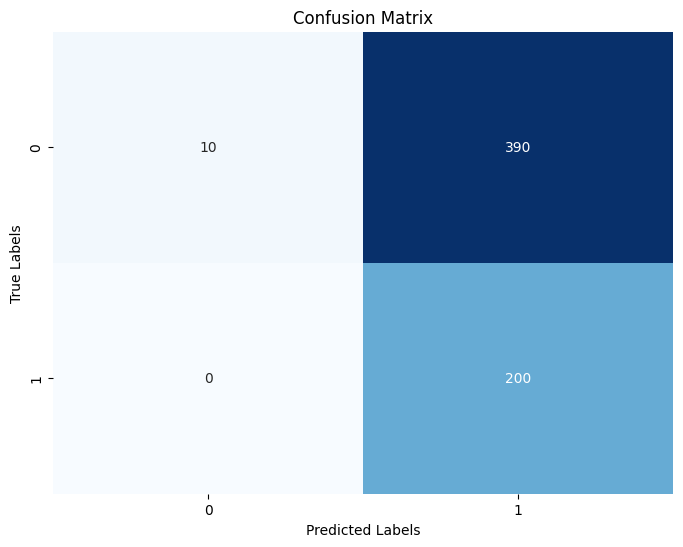

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_test=test_data["flag"].tolist()
# Assuming y_pred and y_test are your predicted and actual labels respectively
y_pred=y_predicted_plain
# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Finetuned LLM

In [ ]:
#Load training data to finetune our model
import pandas as pd
train_data=pd.read_csv("train_data.csv")

In [ ]:
#Convert numerical values to categorical values
train_data['flag'] = train_data['flag'].map({0: 'this is ham', 1: 'this is spam'})
train_data.to_csv("clean.csv")

In [ ]:
# To finetune LLMs data needs to be in jsonl format. Convert our data to jsonl format
import csv
import json

def csv_to_jsonl(csv_file, jsonl_file):
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)

        with open(jsonl_file, 'w') as jsonl:
            for row in reader:
                jsonl.write(json.dumps(row) + '\n')

In [ ]:
#Call the function
csv_to_jsonl('clean.csv', 'final_all.jsonl')

In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
with open('final_all.jsonl', 'r') as file:
    lines = file.readlines()

# Splitting the data into training and evaluation sets (e.g., 80% for training and 20% for evaluation)
split_index = int(len(lines) * 0.8)  # Adjust the percentage as needed
train_data = lines[:split_index]
eval_data = lines[split_index:]

# Writing training data to a new JSONL file
with open('train_data.jsonl', 'w') as train_file:
    train_file.writelines(train_data)

# Writing evaluation data to a new JSONL file
with open('eval_data.jsonl', 'w') as eval_file:
    eval_file.writelines(eval_data)

In [ ]:
#Load train and eval sets
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train_data.jsonl',split="train")
eval_dataset = load_dataset('json', data_files='eval_data.jsonl',split="train")

In [ ]:
#Create a formatting_func to structure training examples as prompts.
def formatting_func(example):
    text = f"### Email Messsage: {example['message']}\n ### Category of message: {example['flag']}"
    return text

In [ ]:
#Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
#Set up the tokenizer. Add padding on the left as it makes training use less memory.

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
#Reformat the prompt and tokenize each sample:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/4073 [00:00<?, ? examples/s]

In [ ]:
#Now let's tokenize again with padding and truncation,
#and set up the tokenize function to make labels and input_ids the same.
max_length = 512 # This was an appropriate max length for our dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
#Reformat the prompt and tokenize each sample:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1019 [00:00<?, ? examples/s]

5092


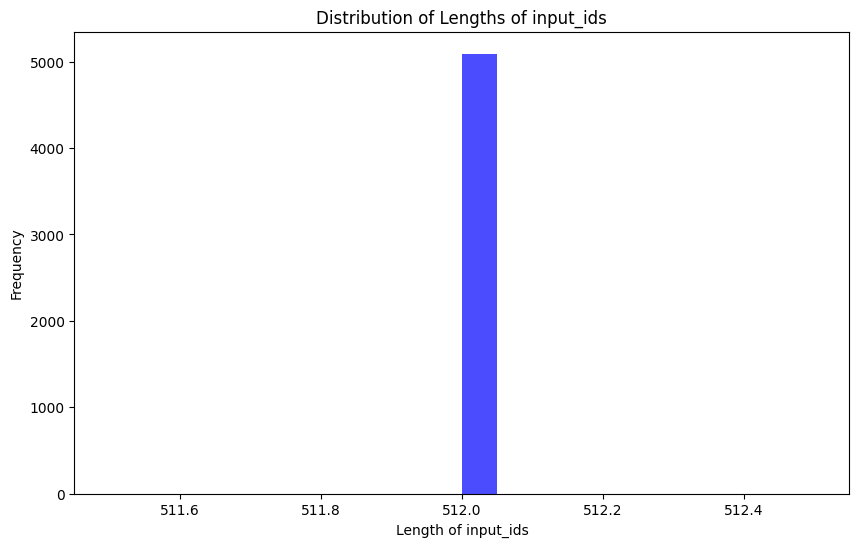

In [ ]:
#Now all the samples should be the same length, max_length.
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
#Set up LoRa
#Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training.
#For that use the prepare_model_for_kbit_training method from PEFT.
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
#Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model.
#Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [ ]:
"""
Here we define the LoRA config.

r is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained.
A higher rank will allow for more expressivity, but there is a compute tradeoff.

alpha is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r,
 and thus a higher value for alpha assigns more weight to the LoRA activations.

we will use r=32 and lora_alpha=64 so that we have more emphasis on the new fine-tuned
data while also reducing computational complexity.
"""
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [ ]:
#Set up the Accelerator. I'm not sure if we really need this for a QLoRA but it seems it can't hurt
#You can always comment out the accelerator if you want to try without.
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model = accelerator.prepare_model(model)

I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 3 hours on the 1x A100G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the max_steps to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the checkpoint-500 model repo in your output dir (mistral-journal-finetune) as your final model in step 6 below.


You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=False,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.470000,2.863924
50,2.270500,2.647786
75,2.263500,2.603988
100,2.246900,2.594951
125,2.261800,2.579792
150,2.091400,2.600681
175,1.906400,2.567458


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

KeyboardInterrupt: ignored

### Try the finetuned model

In [ ]:
#By default, the PEFT library will only save the QLoRA adapters,
#so we need to first load the base model from the Huggingface Hub
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
from huggingface_hub import login

login("huggin face key")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [ ]:
#Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/sample_data/checkpoint-175")

In [ ]:
#Let's try the same eval_prompt and thus model_input as above
eval_prompt = """
How are you?
"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")
outputs = ft_model.generate(**model_input, max_new_tokens=30)
print(eval_tokenizer.decode(outputs[0], skip_special_tokens=True))
